# Detecting Faces: Using a CNN model

Kumpulan data 'Labelled Faces in the Wild' (LFW) adalah kumpulan 13.233 gambar wajah selebriti yang dikumpulkan dari web, dengan individu di setiap gambar diberi label secara manual. Kumpulan data ini dirancang untuk mengeksplorasi, membuat, dan menguji algoritma pengenalan gambar.

Dalam buku catatan ini, kita akan mencoba menjalankan algoritme yang berhasil mengidentifikasi wajah-wajah dalam kumpulan data setelah dilatih tentang wajah-wajah yang serupa. Kami juga akan mempertimbangkan keterbatasan pendekatan ini dalam penerapan algoritme pada data dunia nyata.


Susunan langkah-langkah notebook sebagai berikut:

**1. Library Installation and Data Read-in** </br>mengimport data</br>
**2. Exploratory Data Analysis (EDA)** <br/>
Data exploration, visualisations, dan splitting data kedalam set training/test/validation <br/>
**3. Evaluation Metric Decisions** <br/>
Metrik evaluasi apa yang paling bagus untuk digunakan dalam situasi ini <br/>
**4. Model Construction** <br/>
Digunakan untuk menilai keakuratan teknik CNN pada data pengujian <br/>
**5. Results Analysis** <br/>
menilai dan interpretasi setelah melakukan beberapa tahap dalam membuat model untuk mendeteksi wajah menggunakan CNN <br/>


# 1. Library installation and data read-in

In [2]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("../input/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("../input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("../input/lfw-dataset/pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("../input/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("../input/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("../input/lfw-dataset/peopleDevTrain.csv")

# 2. Exploratory Data Analysis (EDA)

In [3]:
print("Summary:")
print("There are " + 
      str(lfw_allnames.shape[0]) + 
      " unique celebrities in the entire dataset, of whom " + 
      str(sum(lfw_allnames.images > 1)) + 
      " are represented by multiple images. The entire number of images available is " + 
      str(sum(lfw_allnames.images)) + 
      ". The most represented celebrity is " + 
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) + 
      ", with " + 
      str(max(lfw_allnames.images)) + 
      " unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


In [4]:
# membentuk bingkai data sehingga ada satu baris per gambar, disesuaikan dengan file jpg yang relevan
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# ambil sampel acak: 80% data untuk set pengujian
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verifikasi bahwa ada campuran individu yang terlihat dan tidak terlihat dalam set pengujian
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# keduanya secara komprehensif tidak kosong ini bisa dilanjutkan.
# N.B. meskipun tidak menggunakan pemisahan pelatihan/tes ini pada model berikut, ini adalah format data digunakan
# akan digunakan dalam menerapkan model ke kumpulan data lengkap

862
846


print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

1. Kode ini menghitung jumlah nama yang ada di kedua set data (lfw_train dan lfw_test).
2. set(lfw_train.name) dan set(lfw_test.name) masing-masing membuat himpunan unik dari nama-nama di lfw_train dan lfw_test.
3. intersection() digunakan untuk menemukan elemen yang ada di kedua himpunan, sehingga kode ini menghitung berapa banyak nama yang sama di antara dua set data tersebut.

print(len(set(lfw_test.name) - set(lfw_train.name)))

1. Kode ini menghitung jumlah nama yang ada di lfw_test tetapi tidak ada di lfw_train.
2. Operasi - pada himpunan (set) digunakan untuk menemukan elemen yang ada di lfw_test tetapi tidak ada di lfw_train, sehingga kode ini menghitung berapa banyak nama yang unik di lfw_test.

Tujuan:
Kode ini berguna untuk memahami distribusi data, misalnya untuk memastikan bahwa data pelatihan (train) dan pengujian (test) memiliki representasi nama yang berbeda atau sama, yang penting dalam konteks pengenalan wajah agar model tidak overfitting pada data tertentu.

### Image format exploration

In [5]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


### Further data exploration

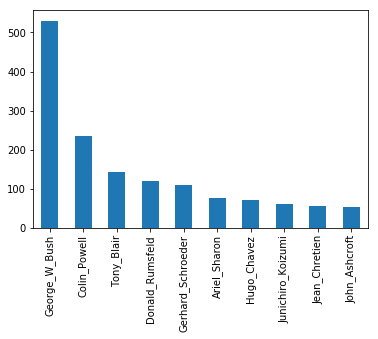

In [ ]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

Disini dapat melihat bahwa ada beberapa tokoh yang terwakili dengan baik di antara 10 tokoh teratas: umumnya tokoh politik dan umumnya laki-laki. Hal ini mempunyai implikasi penting terhadap kegunaan kumpulan data ini dalam generalisasi. Untuk membedakannya lebih jauh, berapa banyak individu yang diwakili oleh satu gambar, membandingkan dengan 530 gambar milik George W Bush 

In [ ]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


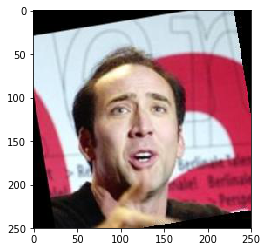

In [ ]:
im = Image.open("../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
plt.imshow(im)

# 3. Evaluation Metric Decisions

**Accuracy** didefinisikan sebagain:

$$ acc = {\frac{tp+tn}{n}} $$

Dimana *tp* adalah nilai prediksi positif yang secara aktualnya, *tn* adalah jumlah prediksi negatif yang sebenarnya, dan *n* adalah jumlah total prediksi. Dengan kata lain, proporsi seluruh prediksilah yang benar. Akurasi adalah indikator yang berguna bahwa model kami berperforma baik, namun mengabaikan nuansa bahwa positif palsu dan negatif palsu mungkin memiliki biaya berbeda yang terkait dengannya. Performanya juga buruk ketika ada ketidakseimbangan kelas yang besar, yang merupakan pertimbangan utama dalam kumpulan data LFW.

Dalam model berikut yaitu, mempertimbangkan dua metrik utama: presisi dan perolehan. **Precision** model untuk kelas prediksi x didefinisikan sebagai

$$ prec_{x} = {\frac{tp_{x}}{tp_{x}+fp_{x}}} $$

Dimana *fp*<sub>x</sub> adalah banyaknya prediksi positif palsu untuk kelas x. Dengan kata lain, presisi mewakili proporsi semua gambar yang *diprediksi* berada di kelas x yang *sebenarnya* termasuk dalam kelas x. **recall** model untuk kelas prediksi x didefinisikan sebagai

$$ rec_{x} = {\frac{tp_{x}}{tp_{x}+fn_{x}}} $$

Dimana *fn*<sub>x</sub> adalah banyaknya prediksi negatif palsu untuk kelas x. Recall menunjukkan proporsi semua gambar yang *sebenarnya* berada di kelas x yang *diprediksi* berada di kelas x. Dimungkinkan juga untuk menggabungkan presisi dan perolehan ke dalam skor F1, tetapi untuk keperluan buku catatan ini, menarik untuk mempertimbangkan implikasi dunia nyata dari metrik terpisah.

Manakah dari metrik berikut yang mungkin lebih berguna? Pertimbangan utama di sini adalah kemungkinan penggunaan algoritma ini di dunia nyata, dan implikasi dari berbagai kesalahan. **Precision** berguna ketika nilai FP yang tinggi. Di sisi lain, **recall** berguna ketika melihat nilai FN yang tinggi. 

# 4. Model 
## 4. a. Preliminary Model: Detecting Faces

Selain evaluasi kinerja yang kuat pada kumpulan data wajah lainnya, MTCNN memiliki manfaat tambahan karena sangat cepat dan mudah diterapkan, seperti yang ditunjukkan dalam sel kode di bawah ini:

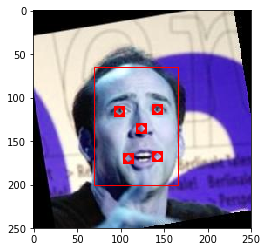

In [9]:
# menggunakan algoritma MTCNN out-of-the-box untuk mengidentifikasi batas wajah pada gambar sampel
detector = MTCNN()
image = cv2.imread("../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
result = detector.detect_faces(image)
# Itu saja - hasilnya sudah terlihat! Sekarang ekstrak batas-batas yang sudah teridentifikasi
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Terakhir, kita plot gambar beserta kotak pembatas wajah dan fitur internal (sudut mata, hidung, dan mulut)
fig,ax = plt.subplots(1)
ax.imshow(image)

# membuat tambalan Persegi Panjang
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')

# Tambahkan patch ke Axes
ax.add_patch(rect)

# Visualisasikan semua fitur internal
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

Disini tidak menggunakan fitur ini pada model CNN utama di bawah ini, namun fitur tersebut akan menjadi masukan fitur yang berguna untuk model mendatang.

CNN tradisional bekerja paling baik ketika kelas-kelasnya seimbang, dan ketika metode klasifikasinya biner, yaitu kita menguji untuk melihat apakah gambar berada dalam kategori A atau B. Kita dapat membuat ulang kondisi ini pada subset data, menggunakan yang paling baik. -individu yang dijadikan sampel: George W Bush. Tujuan dari first-pass CNN ini adalah untuk mengidentifikasi apakah suatu gambar adalah George W Bush atau bukan; kami menggunakan sampel acak dari gambar lain untuk kategori B.

In [10]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [11]:
# melakukan splitting train dan test
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [13]:
#menggunakan pengklasifikasi sekuensial - implementasi CNN 
Bush_classifier = Sequential()
# menambahkan lapisan pertama yang kita tambahkan adalah lapisan konvolusional 2D
# melewati gambar dengan jendela 3x3 dan mengharapkan masukan 250*250 piksel.
Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))

# menambahkan layer pooling untuk mengurangi dimensi
Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# melakukan rataan data dengan mengurangi peta fitur menjadi array 1D
Bush_classifier.add(Flatten())

# menambahkan seluruh lapisan yang terhubung - traditional Multi Layer Perceptron

Bush_classifier.add(Dense(units = 128, activation = 'relu'))

Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model sekarang siap dijalankan, namun ada langkah terakhir yang diperlukan: model akan membaca file pelatihan dari folder pelatihan khusus, jadi kita perlu memastikan semua gambar berada di folder dengan label yang benar.

In [14]:
def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name,data_type))
        path_from = os.path.join('../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('/kaggle/working/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [15]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")


Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


Sekarang semua gambar ada di folder pelatihan/pengujian yang relevan dapat menjalankan algoritma CNN

In [16]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
Bush_training_set = train_datagen.flow_from_directory('/kaggle/working/Bush_train/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('/kaggle/working/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('/kaggle/working/Bush_test/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [17]:
Bush_history = Bush_classifier.fit_generator(Bush_training_set,
                                             # atur langkah per epoch sama dengan jumlah gambar pelatihan
                                             steps_per_epoch = 678,
                                             # ada batas waktu proses enam jam pada Kernel Kaggle, yang membatasi jumlah epoch maksimum
                                             epochs = 8,
                                             validation_data = Bush_val_set,
                                             validation_steps = 100)

Epoch 1/8
678/678 [==============================] - 1072s 2s/step - loss: 0.4246 - accuracy: 0.8682 - val_loss: 0.2098 - val_accuracy: 0.9238
Epoch 2/8
678/678 [==============================] - 1066s 2s/step - loss: 0.0723 - accuracy: 0.9743 - val_loss: 0.6040 - val_accuracy: 0.9176
Epoch 3/8
678/678 [==============================] - 1069s 2s/step - loss: 0.0626 - accuracy: 0.9772 - val_loss: 0.0028 - val_accuracy: 0.9406
Epoch 4/8
678/678 [==============================] - 1068s 2s/step - loss: 0.0301 - accuracy: 0.9892 - val_loss: 0.0705 - val_accuracy: 0.9350
Epoch 5/8
678/678 [==============================] - 1070s 2s/step - loss: 0.0398 - accuracy: 0.9870 - val_loss: 0.1409 - val_accuracy: 0.9533
Epoch 6/8
678/678 [==============================] - 1066s 2s/step - loss: 0.0340 - accuracy: 0.9880 - val_loss: 1.4144 - val_accuracy: 0.9590
Epoch 7/8
678/678 [==============================] - 1073s 2s/step - loss: 0.0117 - accuracy: 0.9962 - val_loss: 0.2518 - val_accuracy: 0.9765

Setelah model tersebut beroperasi, selanjutnya dapat melihat hubungan antara training dan validation loss untuk melihat apakah kemungkinan terjadi overfitting

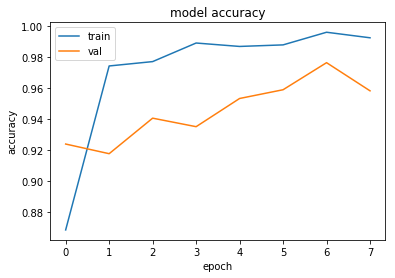

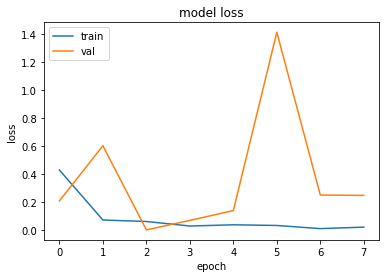

In [18]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Mengingat jumlah epoch yang relatif rendah, model tampaknya masih konvergen - kehilangan/akurasi validasi tidak stabil, yang juga merupakan fungsi dari metode validasi (pada future iterations, cross validation akan menjadi metode yang lebih baik). Namun, akurasi umumnya tinggi pada kedua set, yang menunjukkan bahwa model tersebut berperforma baik. Untuk mengonfirmasi performa model yaitu melihat precision dan recall pada set test/pengujian set, dan membandingkan akurasi dengan label sebenarnya:

In [19]:
from keras.preprocessing import image

# membuat fungsi untuk memprediksi kelas gambar dalam direktori, dengan menggunakan trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name harus menyertakan nama individu yang diprediksi - dapat diedit untuk mengulangi folder di masa mendatang
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else: 
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)


In [20]:
# kelas dilewatkan melalui algoritma dalam urutan acak - kami ingin mengambil urutan kelas
Bush_test_names = []
# kumpulkan semua nama file
for i in range(len(Bush_test_set.filenames)):
    Bush_test_names.append(Bush_test_set.filenames[i])
# ekstrak nama unik, secara berurutan
for i in range(len(Bush_test_names)):
    Bush_test_names[i] = Bush_test_names[i].split("/")[0]
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))

In [21]:
# menghitung prediction
Bush_predictions_0 = predictions("/kaggle/working/Bush_test/"+ Bush_test_name_order[0] + "/",Bush_classifier,binary = True)
Bush_predictions_1 = predictions("/kaggle/working/Bush_test/"+ Bush_test_name_order[1] + "/",Bush_classifier, binary = True)

# membandingkan prediksi dengan kelas aktualnya
Bush_predictions_frame = pd.DataFrame(list(zip(Bush_predictions_0 + Bush_predictions_1,
                                                [0] * len(Bush_predictions_0) + [1] * len(Bush_predictions_1))),
                                       columns = ['Predictions','Actual'])

In [22]:
# fungsi untuk menemukan ketepatan dan perolehan prediksi, untuk sejumlah kelas prediksi
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        precision.append(tp/(tp + fp))
        accuracy.append((tp + tn)/total_preds)
        recall.append(tp/(tp + fn))
    return(accuracy,precision,recall)

In [23]:
Bush_accuracy = prec_acc(Bush_predictions_frame)
print('Precision:' + str(Bush_accuracy[1]))
print('Recall:' + str(Bush_accuracy[2]))
print(Bush_test_name_order)

Precision:[0.8034188034188035, 1.0]
Recall:[1.0, 0.8050847457627118]
['George_W_Bush', 'not_George']


In [24]:
if "Bush_train" in os.listdir("./"):
    shutil.rmtree("./Bush_train")
if "Bush_val" in os.listdir("./"):
    shutil.rmtree("./Bush_val")
if "Bush_test" in os.listdir("./"):
    shutil.rmtree("./Bush_test")


## 4. c. Classifying Faces: Multiple Classes Using a Classic CNN


In [25]:
# mengambil 6 selebriti paling umum

image_paths['name'].value_counts()[:6]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Name: name, dtype: int64

ada ketidakseimbangan pada kelas. untuk memastikan kelas yang lebih seimbang, dapat dilakukan pengambilan sampel dari low-representation individuals, namun demi kecepatan algorithmic, maka akan mengambil sampel dari high-representation individuals:

In [26]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

Kemudian menjalankan model seperti sebelumnya, menyesuaikan untuk beberapa kelas:

In [27]:
# withhold final test data
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# split menjadi validation data
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))
multi_classifier.add(Flatten())
multi_classifier.add(Dense(units = 128, activation = 'relu'))

# softmax activation function
multi_classifier.add(Dense(units = 6, activation = 'softmax')) # softmax activation function untuk menghitung probalitas
# mengubah fungsi kerugian menjadi categorical_crossentropy
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# memindahkan gambar ke direktori terpisah
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val,"val_multi/")
directory_mover(multi_test,"test_multi/")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('/kaggle/working/train_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('/kaggle/working/val_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('/kaggle/working/test_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')


multi_history = multi_classifier.fit_generator(multi_training_set,
                                               # tetapkan langkah per epoch sama dengan jumlah gambar pelatihan
                                               steps_per_epoch = 288,
                                              # karena datanya lebih kecil, kita dapat menjalankannya untuk jangka waktu yang lebih lama
                                               epochs = 14,
                                               validation_data = multi_val_set,
                                               validation_steps = 72)

Moved 288 images to train_multi/ folder.
Moved 72 images to val_multi/ folder.
Moved 90 images to test_multi/ folder.
Found 288 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 90 images belonging to 6 classes.
Epoch 1/14
288/288 [==============================] - 470s 2s/step - loss: 1.8896 - accuracy: 0.6139 - val_loss: 0.2121 - val_accuracy: 0.7639
Epoch 2/14
288/288 [==============================] - 471s 2s/step - loss: 0.1074 - accuracy: 0.9736 - val_loss: 0.6292 - val_accuracy: 0.7639
Epoch 3/14
288/288 [==============================] - 471s 2s/step - loss: 0.0239 - accuracy: 0.9965 - val_loss: 0.4359 - val_accuracy: 0.7917
Epoch 4/14
288/288 [==============================] - 474s 2s/step - loss: 0.0142 - accuracy: 0.9983 - val_loss: 0.1464 - val_accuracy: 0.8056
Epoch 5/14
288/288 [==============================] - 471s 2s/step - loss: 0.0098 - accuracy: 0.9983 - val_loss: 3.1198 - val_accuracy: 0.8056
Epoch 6/14
288/288 [==========================

cek accuracy model dan loss model

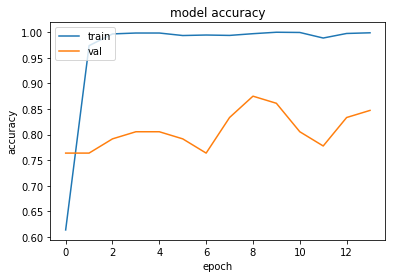

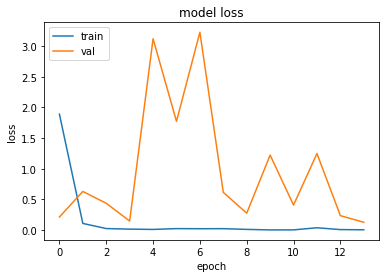

In [28]:
plt.plot(multi_history.history['accuracy'])
plt.plot(multi_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model loss tampak stabil secara umum selama 14 epoch; tapi terlihat masih belum mencapai titik overfitting.

In [29]:
# kelas dilewatkan melalui algoritma dalam urutan acak dan mengambil urutan kelas
multi_test_names = []
# collect all file names
for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])
# extract unique names, in order
for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))

In [30]:
multi_predictions_0 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[0] + "/",multi_classifier,binary=False)
multi_predictions_1 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[1] + "/",multi_classifier,binary=False)
multi_predictions_2 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[2] + "/",multi_classifier,binary=False)
multi_predictions_3 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[3] + "/",multi_classifier,binary=False)
multi_predictions_4 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[4] + "/",multi_classifier,binary=False)
multi_predictions_5 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[5] + "/",multi_classifier,binary=False)


In [31]:
multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 + multi_predictions_3 + multi_predictions_4 + multi_predictions_5,
                                                [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) + [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) + [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5))),
                                       columns = ['Predictions','Actual'])

In [32]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print(multi_test_name_order)

Precision:[1.0, 1.0, 0.875, 0.7777777777777778, 0.9333333333333333, 0.8235294117647058]
Recall:[0.7916666666666666, 0.9333333333333333, 0.9333333333333333, 1.0, 0.9333333333333333, 1.0]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


membuang direktori gambar yang digunakan agar Kernel dapat berjalan:

In [33]:
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")
if "val_multi" in os.listdir("./"):
    shutil.rmtree("./val_multi")
if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")


# 5. Analisis Hasil
Saat menjalankan model George Bush berulang kali, nilai presisi sekitar 81% dan perolehan kembali sekitar 98%. Dengan kata lain, 95% adalah George Bush sebenarnya, dan 81% gambar George Bush diidentifikasi sebagai gambar George Bush. 


Nilai metrik precision sekitar 81% menunjukkan bahwa hanya 19% dari gambar yang di anggap sebagai George Bush sebenarnya adalah gambar orang lain.
Akan tetapi kemungkinan ini tidak bisa diterima. Karena dalam pelabelan berita, kemungkinan besar akan ada orang yang mengetahui hasil QA sebelum hasilnya dipublikasikan, namun dalam pelabelan video langsung, kesalahan ini mungkin terlalu umum untuk berguna dan dapat menyebabkan kesalahan yang memalukan. Tingkat **Recall** sekitar 99,5%+ error seperti ini, akan memberikan keyakinan lebih sebelum menerapkan model ini ke produksi. Namun, seperti yang dibahas di Bagian 3, nilai recall yang sangat tinggi ini dapat memberi kita keyakinan dalam menerapkan model ini pada konteks berbeda di mana terdapat nilai tinggi yang terkait dengan negatif palsu.

Tampilan akurasi dalam model 6 individu ialah nilai precisi dan recall memiliki volume yang serupa tetapi lebih bervariasi antar kelas. Pada model terakhir yang dijalankan presisi rata-rata berada di sekitar 0,8\* untuk semua kelas, tapi performa model pada gambar Tony Blair memberikan presisi yang sangat rendah (0,41\*), sama seperti kebanyakan gambar uji Tony Blair salah diklasifikasikan sebagai gambar George W Bush. Untuk alasan yang sama, tingkat recall yang rendah pada kelas George W Bush. Hal ini menunjukkan potensi kelemahan jaringan yang dilatih pada volume data rendah ketika ditugaskan untuk mengidentifikasi individu yang memiliki demografi serupa dan cenderung muncul dalam gambar serupa. Masalah ini dapat diatasi dengan menambahkan lebih banyak kompleksitas pada model.

